In [1]:
import os
import numpy as np
import pickle
from matplotlib import pyplot as plt

In [2]:
fig_width = 4

In [3]:
results_dir = os.path.join('.', 'results', 'lagrangian_trial')
trial_dirs = [f for f in os.listdir(results_dir)
              if os.path.isdir(os.path.join(results_dir, f))
              and not('.' in f)
              and f != 'pretrained_models']
def get_results(trial_dir):
    with open(os.path.join(results_dir, trial_dir, 'results.pickle'), 'rb') as F:
        results = pickle.load(F)
    return results
swept_args = {
    'critic_method': ['gan', 'autoencoder', 'pixel_space'],
    'gen_loss_fn': ['L1', 'MSE'],
    'ce_warmup_iter': [0, 1, 10],
    'ce_max_iter': [1, 10, 100],
    'ce_opt': ['Adam', 'SGD'],
    'proj_rec_updates': [True, False],
    'gen_opt_kwargs': ['lr: 0.01', 'lr: 0.1', 'lr: 0.1, mtm: 0.5', 'lr: 0.01, mtm: 0.5']
} 
from adversarial_trial_gridsearch import unwrap_config_dict
settings = unwrap_config_dict(swept_args)
results = []
for trial_dir in trial_dirs:
    if not(os.path.exists(os.path.join(results_dir, trial_dir, 'results.pickle'))) or (trial_dir in ['pretrained_models']):
        continue
    idx = int(trial_dir.split('_')[-1])
    result = get_results(trial_dir)
    results.append((settings[idx], result))

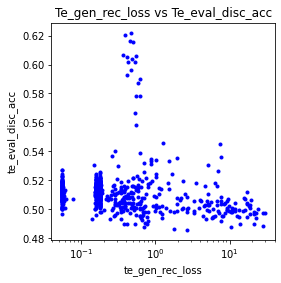

In [4]:
def compare_performance_metrics(metric_A, metric_B):
    fig, ax = plt.subplots(figsize=(fig_width, fig_width))
    metric_A_vals, metric_B_vals = [], []
    for result in results:
        metric_A_vals.append(result[1][metric_A][-1])
        metric_B_vals.append(result[1][metric_B][-1])
    ax.plot(metric_A_vals, metric_B_vals, '.', color='blue')
    ax.set_xlabel(metric_A)
    ax.set_ylabel(metric_B)
    ax.set_title('{} vs {}'.format(metric_A.capitalize(), metric_B.capitalize()))
    if 'loss' in metric_A:
        ax.set_xscale('log')
    if 'loss' in metric_B:
        ax.set_yscale('log')
compare_performance_metrics('te_gen_rec_loss', 'te_eval_disc_acc')

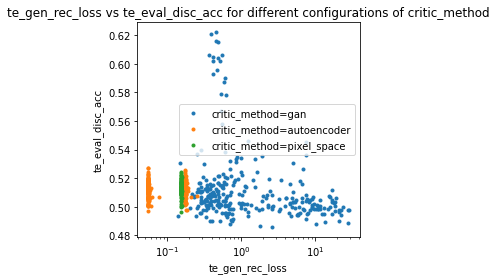

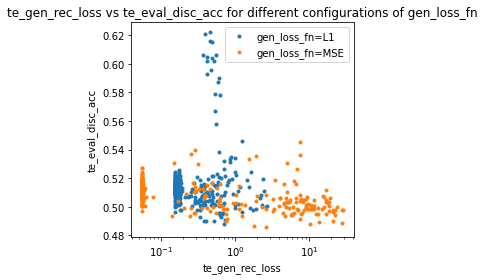

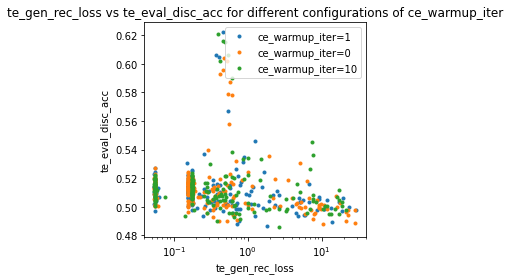

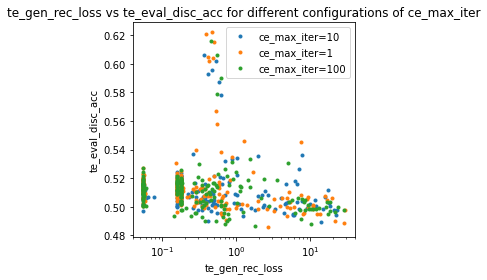

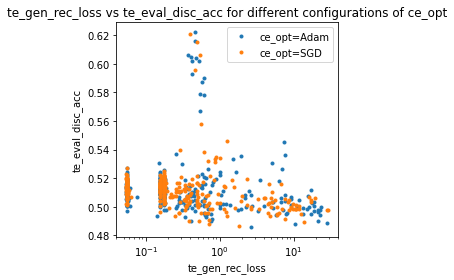

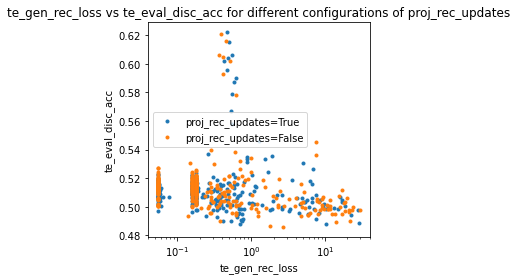

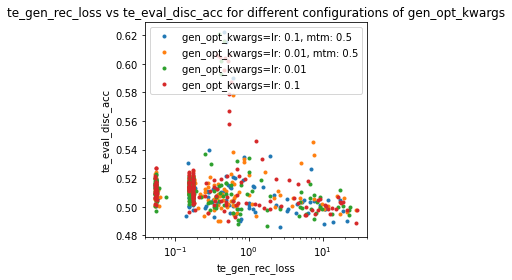

In [5]:
def plot_performance_vs_hparam(hparam, performance_metrics):
    fig, ax = plt.subplots(figsize=(fig_width, fig_width))
    values = {}
    for result in results:
        hparam_value = result[0][hparam]
        perf_values = [result[1][pm][-1] for pm in performance_metrics]
        if not hparam_value in values.keys():
            values[hparam_value] = [[], []]
        values[hparam_value][0].append(perf_values[0])
        values[hparam_value][1].append(perf_values[1])
    for hparam_value, curves in values.items():
        ax.plot(curves[0], curves[1], '.', label='{}={}'.format(hparam, hparam_value))
    ax.legend()
    if 'loss' in performance_metrics[0]:
        ax.set_xscale('log')
    if 'loss' in performance_metrics[1]:
        ax.set_yscale('log')
    ax.set_xlabel(performance_metrics[0])
    ax.set_ylabel(performance_metrics[1])
    ax.set_title('{} vs {} for different configurations of {}'.format(
        performance_metrics[0], performance_metrics[1], hparam
    ))
    plt.tight_layout()
for hparam in swept_args.keys():
    plot_performance_vs_hparam(hparam, ['te_gen_rec_loss', 'te_eval_disc_acc'])